Install necessary packages.

In [1]:
# %pip install scikit-learn

Load dataset.

In [2]:
# Step 1: Open the file in read mode
with open('../data/dialog_acts.dat', 'r') as file:
    # Step 2: Read the content of the file
    data = file.read().split('\n')

# Step 3: Display the content
# print(data)

# Lists of  dialog acts and their descriptions
dialog_acts = ["ack", "affirm", "bye", "confirm", "deny", "hello", "inform", "negate", "null", "repeat", "reqalts", "reqmore", "request", "restart", "thankyou"]
# descriptions = ["acknowledgment", "positive confirmation", "greeting at the end of the dialog", "check if given information confirms to query", "reject system suggestion", "greeting at the start of the dialog", "state a preference or other information", "negation", "noise or utterance without content", "ask for repetition", "request alternative suggestions", "request more suggestions", "ask for information", "attempt to restart the dialog", "express thanks"]

From the assignment descripition: "In case an utterance was labeled with two different dialog acts, only the first dialog act is used as a label". See below. After testing, doesn't seem appliccable here, all lines where the first AND second word of are in the dialog_act list, word1 and word2 are the same, so it is not a different dialog act. There seems to be one line which is empty.

In [3]:
# # Check if first or first two words are dialog acts and which one(s)
# for line in data:
#     words = line.split()
#     if len(words) < 2:
#         print(words)
#         continue
#     if ((words[0] in dialog_acts) and (words[1] in dialog_acts) and (words[0] != words[1])):
#         print(words)

Let's create a pandas DataFrame.

In [4]:
import pandas as pd

label = []
sentence = []
for line in data:
    if line > '':
        line = line.split()
        label.append(line[0])
        sentence.append(" ".join(line[1:]))
    
df = pd.DataFrame({'sentence': sentence, 'label': label})
df.head()

,sentence,label
0,im looking for a moderately priced restaurant ...,inform
1,any part of town,inform
2,bistro food,inform
3,is there a moderately priced restaurant that s...,confirm
4,yes,affirm


Split data into training and test datasets.

In [5]:
print(df['sentence'].value_counts())

sentence
thank you good bye                              2565
phone number                                     914
yes                                              803
address                                          678
i dont care                                      613
                                                ... 
west part of town cuban food                       1
priced                                             1
lebanese restaurant in the west part of town       1
tailand                                            1
im looking for korean food any price range         1
Name: count, Length: 5359, dtype: int64


Plot thedistribution of the data across the labels: very skew, this can give problems of imbalanced classes.

label
inform      10160
request      6494
thankyou     3259
reqalts      1747
null         1612
affirm       1156
negate        435
bye           266
confirm       172
hello          93
repeat         33
ack            28
deny           27
restart        14
reqmore         5
Name: count, dtype: int64
Total amount of distinct labels: 15


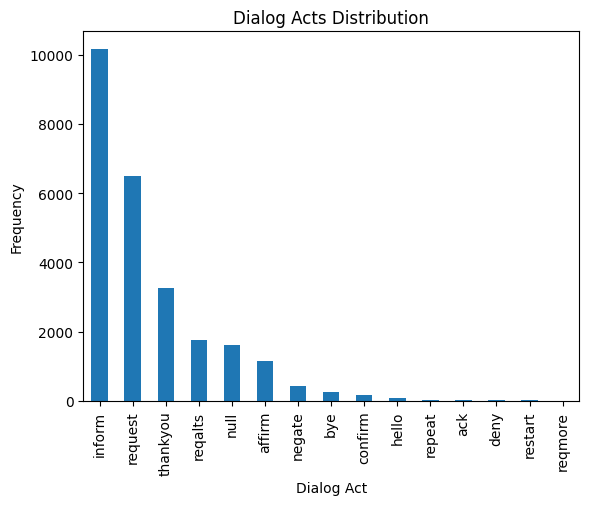

In [6]:
print(df['label'].value_counts())
print("Total amount of distinct labels:", df['label'].nunique())

import matplotlib.pyplot as plt

# df is our DataFrame and it has a 'label' column
plot = df['label'].value_counts().plot(kind='bar', title='Dialog Acts Distribution')
plot.set_xlabel('Dialog Act')
plot.set_ylabel('Frequency')

# Display the plot
plt.show()

Transform the textual labels into numerical labels, for ML models to work with.

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
df['numerical_label'] = label_encoder.fit_transform(df['label'])

# Display the DataFrame with numerical labels
print(df.head())


                                            sentence    label  numerical_label
0  im looking for a moderately priced restaurant ...   inform                6
1                                   any part of town   inform                6
2                                        bistro food   inform                6
3  is there a moderately priced restaurant that s...  confirm                3
4                                                yes   affirm                1


Create look-up table: to convert the numerical labels back to the textual labels.

In [8]:
# Create a dictionary to map the numerical labels back to the original labels

lookup_table = {index: label for index, label in enumerate(label_encoder.classes_)}
print(lookup_table)

{0: 'ack', 1: 'affirm', 2: 'bye', 3: 'confirm', 4: 'deny', 5: 'hello', 6: 'inform', 7: 'negate', 8: 'null', 9: 'repeat', 10: 'reqalts', 11: 'reqmore', 12: 'request', 13: 'restart', 14: 'thankyou'}


Split the data according to the assignment descriptions: 85% training data and a 15% testset.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["sentence"],df["numerical_label"],test_size=0.15,shuffle=True)

Check if split went well.

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print("Training size:", (X_train.shape[0]/len(df)) * 100)
print("Test size:", (X_test.shape[0]/len(df)) * 100)

print("Sample training data:", X_train[0])

(21675,)
(3826,)
(21675,)
(3826,)
Training size: 84.9966667973805
Test size: 15.003333202619503
Sample training data: im looking for a moderately priced restaurant that serves


Basline Model 1: always assign the majority label plus evaluation in accuracy.

In [11]:
def baseline_model_majority(data):
    """Baseline model always returns the majority class"""
    # return data.value_counts().idxmax()
    return 6

def evaluate_baseline(data, labels):
    """Evaluate the baseline model"""
    predictions = [baseline_model_majority(data) for _ in range(len(data))]
    accuracy = sum(predictions == labels) / len(labels)
    return accuracy

baseline_model_majority(df['sentence'])
evaluate_baseline(df['sentence'], df['numerical_label'])

0.39841574840202343

Baseline model 2: handcrafted keyword selection plus a more extensive evaluation, such that I was able to adapt the keywords according to the results.

In [12]:
import pandas as pd
import re
from sklearn.metrics import classification_report

def baseline_model_rules(data):
    """Baseline model based on hand-crafted rules: keyword matching"""
    keywords = {
        'ack': [r'\b(thatll do dear|im good|just pick|well take|okay um|great day)\b'],
        'affirm': [r'\b(ye|yes|yeah)\b', r'^(right)$'],
        'bye': [r'\b(okay thank you and good bye|alright thank you good bye|see you)\b', r'^(goodbye|good bye|bye)$'],
        'confirm': [r'\b(does it|do they)\b'],
        'deny': [r'\b(dont want|no not|wrong|something else|not important)\b'],
        'hello': [r'\b(hello|hi|hey)\b'],
        'inform': [r'\b(spanish|italian|east|west|it doesnt matter|korean|moroccan|center|north|doesnt matter|expensive|cheap|south|any|dont care|vietnamese|irish|spaninsh|oriental|portugese|indian|lebanese|thai|chinese|african|asian|part|town|priced|moderate|gastropub)\b'],
        'negate': [r'\b(no |not|never)\b'],
        'null': [r'\b(sil|noise|cough|unintelligible\n)\b'],
        'repeat': [r'\b(try this again|again please)\b', r'^(please repeat|back|again|repeat|repeat that|go back|can you repeat that)$'],
        'reqalts': [r'\b(how about|what about|next|anything else|is there)\b'],
        'reqmore': [r'^(more)$'],
        'request': [r'\b(type of food|phone number|address|need|post code|price range)\b'],
        'restart': [r'\b(start|oh jesus|reset)\b'],
        'thankyou': [r'\b(thank you|thanks|appreciate|thank you good bye)\b']
    }
    
    def match_keywords(sentence):
        matches = []
        for label, patterns in keywords.items():
            for pattern in patterns:
                if re.search(pattern, sentence.lower()):
                    matches.append(label)
        return matches[0] if matches else 'null'  # Return first match or 'null'

    predictions = data.apply(match_keywords)
    return predictions

# Assuming df is your DataFrame with 'sentence' and 'label' columns
predictions = baseline_model_rules(df['sentence'])

# Evaluate the baseline model
print(classification_report(df['label'], predictions))


              precision    recall  f1-score   support

         ack       0.60      0.43      0.50        28
      affirm       1.00      0.94      0.97      1156
         bye       1.00      0.78      0.88       266
     confirm       0.29      0.35      0.32       172
        deny       0.68      0.93      0.78        27
       hello       0.94      0.98      0.96        93
      inform       0.88      0.77      0.82     10160
      negate       0.58      0.18      0.27       435
        null       0.33      0.96      0.50      1612
      repeat       1.00      0.85      0.92        33
     reqalts       0.88      0.52      0.66      1747
     reqmore       1.00      1.00      1.00         5
     request       0.99      0.89      0.94      6494
     restart       1.00      1.00      1.00        14
    thankyou       0.99      0.99      0.99      3259

    accuracy                           0.82     25501
   macro avg       0.81      0.77      0.77     25501
weighted avg       0.89   

**Setup of our machine learning (ML) pipeline**

We will use Bag-of-Words (BOW) as input for our ML classifiers. Preprocessing may also involve many steps like tokenization, removing stop words, stemming/lemmatization etc.

In [13]:
# Bag of words (BOW)
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform X_train to BOW representation
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Convert to array for better readability (optional)
X_train_bow_array = X_train_bow.toarray()
X_test_bow_array = X_test_bow.toarray()

# # print("Feature names:", vectorizer.get_feature_names_out())
# print("Normal representation:\n", X_train[0])
# print("BOW representation:\n", X_train_bow[0])
# print("BOW representation:\n", X_train_bow_array[0])
# # Count the number of 1's in X_train_bow_array[0]
# count_ones = np.count_nonzero(X_train_bow_array[0] == 1)
# print("Number of 1's in X_train_bow_array[0]:", count_ones)

1. ML1: Decision Tree

In [14]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_bow, y_train)


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions on the test data
y_pred = clf.predict(X_test_bow)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9764767381076843
Precision: 0.9779990316680564
Recall: 0.9764767381076843
F1 Score: 0.9767262213534046
Confusion Matrix:
 [[   4    0    0    0    0    0    0    0    1    0    0    0    0    0]
 [   0  163    0    0    0    0    1    0    0    0    0    1    0    0]
 [   0    0   39    0    0    0    0    0    0    0    0    0    0    2]
 [   0    0    0   23    0    0    1    0    0    0    1    4    0    0]
 [   0    0    0    0    1    0    1    1    0    0    0    0    0    0]
 [   0    0    0    0    0   13    0    0    0    0    0    0    0    0]
 [   1    0    0    1    1    0 1486    1   30    0    8    4    0    1]
 [   0    0    0    0    0    0    1   62    0    0    0    0    0    0]
 [   0    0    0    0    0    0    1    0  223    0    0    1    0    0]
 [   0    0    0    0    0    0    0    0    1    5    0    0    0    0]
 [   1    0    0    0    0    0    7    0    5    0  240    0    0    0]
 [   0    0    0    0    0    0    2    1    4    0    1  954  

2. ML2: Logistic Regression Classifier

In [16]:
# Logistic Regression Classification Model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train_bow, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_bow)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9803972817564035
Precision: 0.9791796893755179
Recall: 0.9803972817564035
F1 Score: 0.9795611706594028
Confusion Matrix:
 [[   0    0    0    0    0    0    2    0    3    0    0    0    0    0]
 [   0  164    0    0    0    0    0    0    1    0    0    0    0    0]
 [   0    0   38    0    0    0    0    0    1    0    0    0    0    2]
 [   0    0    0   27    0    0    2    0    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    1    0    0    1    0    0    0]
 [   0    0    0    0    0   13    0    0    0    0    0    0    0    0]
 [   1    0    0    1    0    0 1511    0    2    0   13    4    0    1]
 [   0    0    0    0    0    0    0   63    0    0    0    0    0    0]
 [   0    0    0    0    0    0   16    0  206    0    0    3    0    0]
 [   0    0    0    0    0    0    2    0    0    4    0    0    0    0]
 [   0    0    0    1    0    0    5    0    3    0  244    0    0    0]
 [   0    0    0    0    0    0    2    1    0    0    0  959  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  